# Linear Methods

In [338]:
import warnings
warnings.filterwarnings("ignore")

In [118]:
import numpy as np
import pandas as pd
import cvxpy as cp
import quantstats as qs
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from qs import calc_factor, calc_return
from pypfopt.efficient_frontier import EfficientFrontier

## Prepare Data

In [14]:
crsp = pd.read_parquet("./data/crsp.parquet")
glb = pd.read_parquet("./data/glb.parquet")
mfis = pd.read_parquet("./data/mfis.parquet")
famafrench = pd.read_parquet("./data/famafrench.parquet") 
optionmetrics = pd.read_parquet("./data/optionmetrics.parquet")

In [375]:
def combine_factor(freq, **kwargs):
    factor = pd.DataFrame(
        {name: factor.resample(freq).last().stack() for name, factor in kwargs.items()}
    )
    return factor

def calc_factor(crsp, famafrench, mfis, glb, freq):
    from statsmodels.regression.rolling import RollingOLS
    from sklearn.preprocessing import quantile_transform
    
    # Estimate factor exposure
    portfolio = crsp.loc[crsp.date >= "1994-01-01", :].pivot(
        index="date", columns="permno", values="ret"
    )
    portfolio = portfolio.sub(famafrench.loc[portfolio.index, "rf"], axis=0)
    factor = famafrench.loc[portfolio.index, ["mktrf", "smb", "hml", "mom"]].assign(
        alpha=1
    )
    betas = []
    for permno in portfolio:
        ret = portfolio[permno]
        res = RollingOLS(endog=ret, exog=factor, window=756).fit(params_only=True)
        params = res.params
        params["resid"] = ret - factor.mul(params).sum(1)
        params["permno"] = permno
        betas.append(params)
    beta = pd.concat(betas).reset_index().dropna()

    # Pivot data for calculation
    ret = crsp.pivot(index="date", columns="permno", values="ret").sub(
        famafrench.rf, axis=0
    )
    logret = np.log(ret + 1)
    shrout = crsp.pivot(index="date", columns="permno", values="shrout")
    vol = crsp.pivot(index="date", columns="permno", values="volume")
    close = crsp.pivot(index="date", columns="permno", values="close")
    dv = vol.mul(close)
    mktrf = beta.pivot(index="date", columns="permno", values="mktrf")
    resid = beta.pivot(index="date", columns="permno", values="resid")

    # Estimate price trend
    # 1-month cumulative return
    mom_1m = logret.rolling(21).sum()
    # 11-month cumulative returns ending 1-month before
    mom_12m = logret.shift(21).rolling(11 * 21).sum()
    # Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
    mom_6m = logret.shift(21).rolling(5 * 21).sum()
    mom_12m_6m = logret.shift(6 * 21).rolling(5 * 21).sum()
    chmom = mom_6m - mom_12m_6m
    # Max daily returns from calendar month t-1
    maxret = logret.rolling(21).max()
    # Cumulative returns months t-36 to t-13
    mom_36m = logret.shift(12 * 21).rolling(24 * 21).sum()

    # Estimate liquidity
    # Average monthly trading volume for most recent three months divided by number of shares
    turn = vol.shift(21).mean().div(shrout)
    # Monthly std dev of daily share turnover
    turn_std = vol.div(shrout).rolling(21).std()
    # Natural log of market cap
    logcap = np.log(close) + np.log(shrout)
    # Natural log of trading volume times price per share from month t-2
    dolvol = np.log(dv.shift(21).rolling(21).mean())
    # Average of daily (absolute return / dollar volume)
    ill = ret.abs().div(dv)

    # Estimate risk
    # Standard dev of daily returns from month t-1
    retvol = ret.rolling(21).std()
    # Market beta squared
    mktrf_sq = mktrf.pow(2)
    # Idiosyncratic return volatility
    idovol = resid.rolling(756).std()

    # Combine factors to the required frequency
    factor = combine_factor(
        freq,
        mom_1m=mom_1m,
        mom_12m=mom_12m,
        chmom=chmom,
        maxret=maxret,
        mom_36m=mom_36m,
        turn=turn,
        turn_std=turn_std,
        logcap=logcap,
        dolvol=dolvol,
        ill=ill,
        retvol=retvol,
        mktrf_sq=mktrf_sq,
        idovol=idovol,
    )
    if freq == "D":
        beta_ = beta.set_index(["date", "permno"])
        mfis_ = mfis.set_index(["date", "permno"])
        glb_ = glb.set_index(["date", "permno"])
    else:
        beta_ = beta.groupby([pd.Grouper(key="date", freq=freq), "permno"]).last()
        mfis_ = mfis.groupby([pd.Grouper(key="date", freq=freq), "permno"]).last()
        glb_ = glb.groupby([pd.Grouper(key="date", freq=freq), "permno"]).last()
    factor = factor.join(beta_).join(mfis_).join(glb_)
    # Fill missing value with cross sectional median
    factor = factor.groupby("date").transform(lambda x: x.fillna(x.median())).dropna()
    return factor

In [376]:
factor = calc_factor(crsp, famafrench, mfis, glb, "W-FRI")
ret = calc_return(crsp, famafrench, "W-FRI")

## Feature Selection

In [391]:
import statsmodels.api as sm

In [396]:
X = factor["2000-01-01":"2012-12-31"].drop(columns=["mom_12m", "turn", "turn_std", "ill", "dolvol", "mom", "mfis_182", "mfis_273"])
y = ret.shift(-1).loc["2000-01-01":"2012-12-31"]
sm.OLS(endog=y, exog=X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              36.95
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                   3.06e-128
Time:                        18:52:33   Log-Likelihood:                          48536.
No. Observations:               33900   AIC:                                 -9.704e+04
Df Residuals:                   33882   BIC:                                 -9.688e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mom_1m         0.0659      0.003     20.169      0.000       0.060       0.072
chmom          0.0011      0.001      1.303      0.193      -0.001       0.003
maxret        -0.1488      0.024     -6.330      0.000      -0.195      -0.103
mom_36m        0.0014      0.001      1.859      0.063   -7.66e-05       0.003
logcap        -0.0007      0.000     -5.712      0.000      -0.001      -0.000
retvol         0.6013      0.063      9.613      0.000       0.479       0.724
mktrf_sq      -0.0013      0.001     -0.987      0.324      -0.004       0.001
idovol         0.1459      0.059      2.491      0.013       0.031       0.261
mktrf          0.0030      0.003      1.081      0.280      -0.002       0.008
smb           -0.0024      0.001     -2.817      0.005      -0.004      -0.001
hml           -0.0011      0.001     -1.855      0.064      -0.002    6.02e-05
alpha         -2.1882      0.611     -3.581      0.000      -3.386      -0.990
resid         -0.0246      0.015     -1.603      0.109      -0.055       0.005
mfis_30       -0.0019      0.001     -2.420      0.016      -0.003      -0.000
mfis_91       -0.0022      0.001     -1.797      0.072      -0.005       0.000
mfis_365      -0.0046      0.001     -3.636      0.000      -0.007      -0.002
glb2_30       -0.7085      0.246     -2.877      0.004      -1.191      -0.226
glb3_30        0.6803      0.245      2.778      0.005       0.200       1.160
==============================================================================
Omnibus:                    10807.031   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357333.485
Skew:                           0.892   Prob(JB):                         0.00
Kurtosis:                      18.805   Cond. No.                     3.16e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Tuning

In [355]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=126,
        test_period_length=21,
        lookahead=0,
        date_idx="date",
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates[self.date_idx] > days[train_start])
                & (dates[self.date_idx] <= days[train_end])
            ].index
            test_idx = dates[
                (dates[self.date_idx] > days[test_start])
                & (dates[self.date_idx] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self):
        return self.n_splits


In [397]:
def get_train_valid(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    return X_train, y_train, X_val, y_val

In [421]:
def cross_validation(reg):
    r2_ = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
        X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        r2_.append(r2)
        print(f"fold: {fold}, r2: {r2}")
    print(f"Avg. r2: {np.mean(r2_)}")

In [512]:
cv = MultipleTimeSeriesCV(n_splits=7,
                          train_period_length=6*52,
                          test_period_length=52,
                          lookahead=1)
reg = LinearRegression()
cross_validation(reg)

fold: 0, r2: 0.00904382358283673
fold: 1, r2: 0.004790371272468397
fold: 2, r2: -0.011055274162036888
fold: 3, r2: 0.008040993676097674
fold: 4, r2: -0.008288683798382213
fold: 5, r2: -0.001057145351137434
fold: 6, r2: -0.01553509548989851
Avg. r2: -0.002008715752864606


In [513]:
reg = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
cross_validation(reg)

fold: 0, r2: 0.008851683491542417
fold: 1, r2: 0.004869265574301118
fold: 2, r2: -0.01121078142134424
fold: 3, r2: 0.007812690442928316
fold: 4, r2: -0.008378940238638277
fold: 5, r2: -0.0008132656342558775
fold: 6, r2: -0.015360466020584385
Avg. r2: -0.002032830543721561


In [514]:
reg = make_pipeline(StandardScaler(), Lasso(alpha=0.0001))
cross_validation(reg)

fold: 0, r2: 0.008939107664598489
fold: 1, r2: 0.005518385442341622
fold: 2, r2: -0.005956002536175564
fold: 3, r2: 0.005819186944575172
fold: 4, r2: -0.0064398048850942136
fold: 5, r2: 0.0017832885662852904
fold: 6, r2: -0.01280797084356422
Avg. r2: -0.00044911566386191773


## Backtest

In [515]:
X = factor["2000-01-01":"2019-11-30"] 
y = ret.shift(-1).loc["2000-01-01":"2019-11-30"]
reg = make_pipeline(StandardScaler(), Lasso(alpha=0.0001))

In [516]:
predictions = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
    reg.fit(X_train, y_train)
    predictions.append(pd.Series(reg.predict(X_val).reshape(-1), index=y_val.index))
y_pred = pd.concat(predictions).sort_index()
y_val = y[y_pred.index]
r2_score(y_val, y_pred)

0.0024277488815610537

In [517]:
crsp["w_cap"] = (crsp.close * crsp.shrout).groupby(crsp.date).apply(lambda x: x / x.sum())

In [518]:
def calc_w():
    w_optimal = pd.Series(None, index=y_pred.index, dtype="float")
    w_caps = crsp.pivot(index="date", columns="permno", values="w_cap").resample("W-FRI").last()
    unique_dates = y_pred.index.get_level_values("date").unique()
    for date in tqdm(unique_dates):
        mu = y_pred[date].to_numpy()
        Sigma = crsp[crsp.date <= date].pivot(index="date", columns="permno", values="ret").tail(252).cov().to_numpy()
        w_cap = w_caps.loc[date, :].to_numpy()
        ef = EfficientFrontier(mu, Sigma)
        ef.add_constraint(lambda x : x <= w_cap * 1.1)
        ef.add_constraint(lambda x : x >= w_cap * 0.9)
        w = ef.min_volatility()
        w_optimal[date] = pd.Series(w)
    return w_optimal

In [521]:
bt = crsp.set_index(["date", "permno"]).loc["2013-01-01":"2019-12-31", ["ret", "w_cap"]]
bt["w_optimal"] = calc_w()
bt["w_optimal"] = bt.groupby("permno").w_optimal.transform(lambda x: x.fillna(method="ffill").shift(1))
bt = bt.dropna()

100%|██████████| 364/364 [00:22<00:00, 16.06it/s]


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-01-07  2013-01-07
End Period                 2019-12-31  2019-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          140.08%     139.51%
CAGR﹪                     13.36%      13.32%

Sharpe                     1.22        1.21
Smart Sharpe               1.19        1.17
Sortino                    1.75        1.72
Smart Sortino              1.69        1.67
Sortino/√2                 1.23        1.22
Smart Sortino/√2           1.2         1.18
Omega                      1.24        1.24

Max Drawdown               -13.08%     -13.02%
Longest DD Days            406         412
Volatility (ann.)          10.74%      10.84%
R^2                        1.0         1.0
Calmar                     1.02        1.02
Skew                       -0.45       -0.45
Kurtosis                   2.95        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-01-23,2015-08-25,2016-03-04,406,-13.081091,-11.646850
2,2018-12-03,2018-12-24,2019-03-01,88,-11.085161,-8.974527
3,2018-01-29,2018-05-02,2018-09-13,227,-10.193168,-10.042601
4,2016-07-25,2016-12-01,2017-02-03,193,-6.059730,-5.399219
5,2013-05-16,2013-06-20,2013-07-15,60,-5.980145,-5.141238


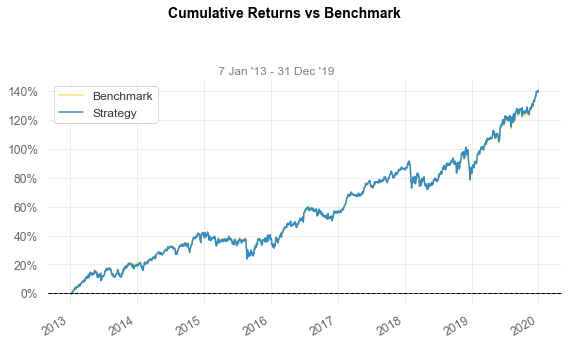

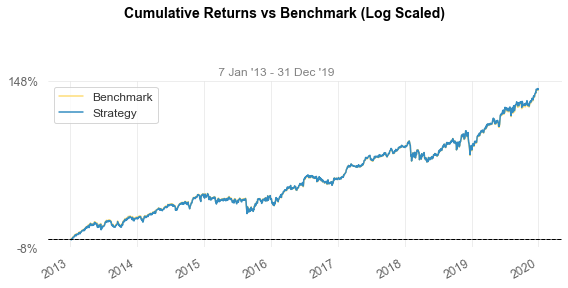

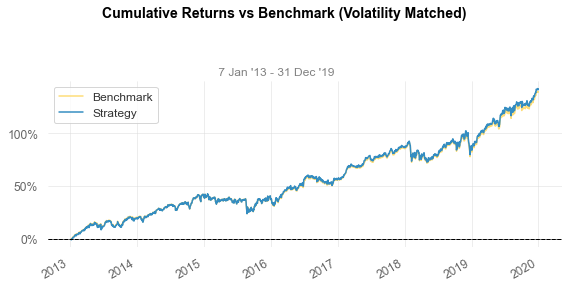

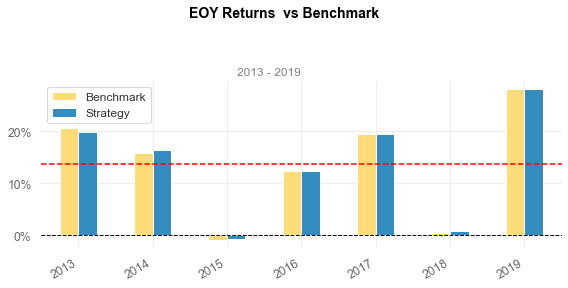

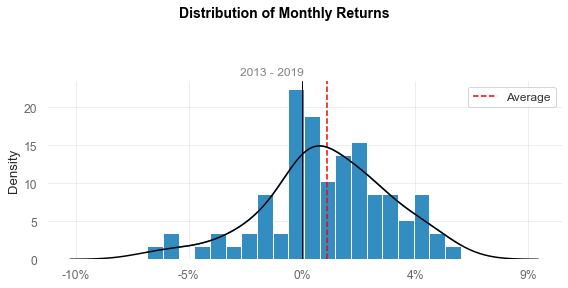

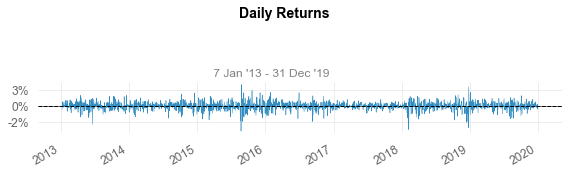

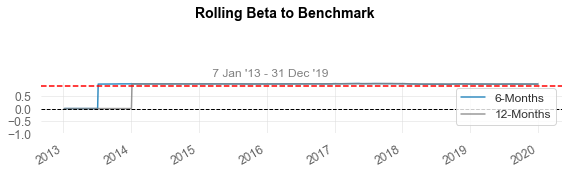

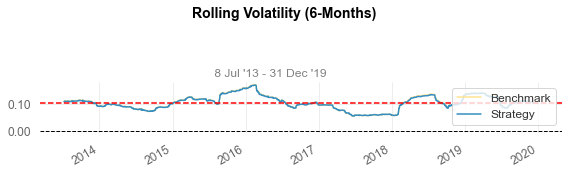

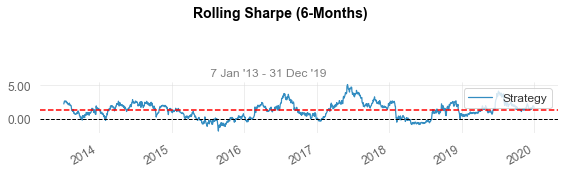

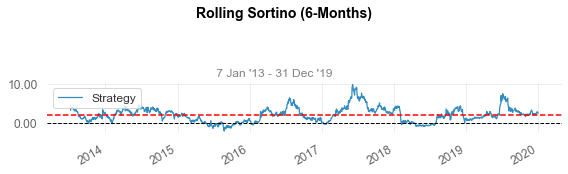

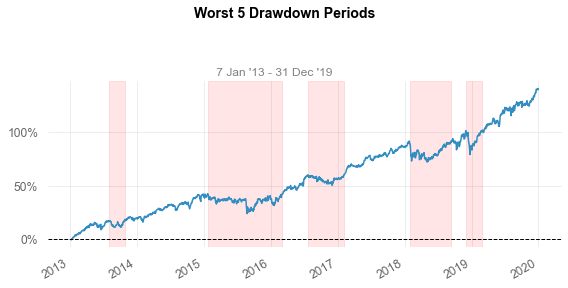

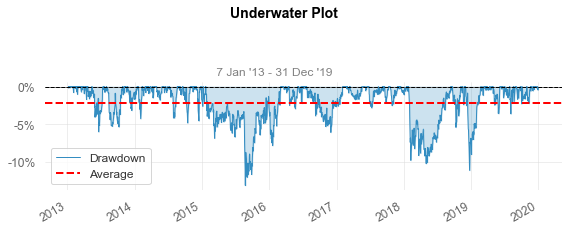

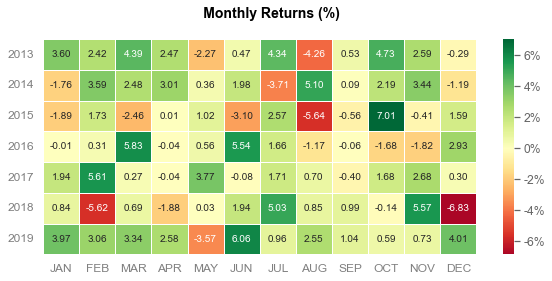

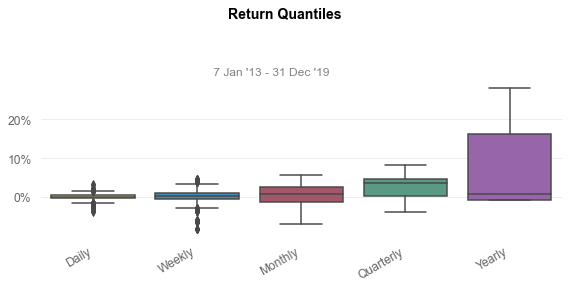

In [522]:
bnch_ret = (bt.ret * bt.w_cap.groupby("permno").shift(1)).groupby("date").sum()
bt_ret = (bt.ret * bt.w_optimal).groupby("date").sum()
qs.reports.full(bt_ret, bnch_ret)